# AMQ Structures for Status List

First, we need an AMQ implementation that is somewhat safe. Bloom filters seem to be our best bet. To be super-safe, they need to use only cryptographic hash functions.

## Setup

In [1]:
import uuid
import time
import matplotlib.pyplot as plt
import math
import statistics
from amqStatusList import FilterCascade


def take_single_measurement(num_included, num_excluded, fprs=None):
    test_cascade = None
    start_time = time.time()
    tries = 0
    while not test_cascade:
        try:
            revoked = []
            for i in range(num_included):
                revoked.append(uuid.uuid4())
            valid = []
            for i in range(num_excluded):
                valid.append(uuid.uuid4())
            start_time = time.time()
            test_cascade = FilterCascade(revoked, valid, fprs)
        except:
            tries = tries + 1
            if tries > 3:
                break
    if not test_cascade:
        raise Exception(
            f"Cascade construction failed repeatedly for {num_included} inclusions and {num_excluded} exclusions with {fprs} fpr targets")
    elapsed_time = time.time() - start_time
    return {"time": elapsed_time, "data_size": test_cascade.size_in_bits() / 8.0, "depth": len(test_cascade.filters)}


def take_measurement(num_included, num_excluded, fprs=None):
    # take 3 measurements and return the median
    results = []
    for i in range(3):
        results.append(take_single_measurement(num_included, num_excluded, fprs))
    return {
        "time": statistics.median(map(lambda x: x["time"], results)),
        "data_size": statistics.median(map(lambda x: x["data_size"], results)),
        "depth": statistics.median(map(lambda x: x["depth"], results))
    }


def plot_data(x_series, y_series_arr, labels, x_label, y_label, title):
    assert len(y_series_arr) == 1 or len(y_series_arr) == len(labels)
    if len(y_series_arr) == 1:
        plt.plot(x_series, y_series_arr[0], marker='o')
    else:
        for i in range(len(y_series_arr)):
            plt.plot(x_series, y_series_arr[i], marker='o', label=labels[i])
        plt.legend()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()


## Sanity check

In [2]:
def sanity_check():
    positives = []
    for i in range(10_000):
        positives.append(uuid.uuid4())
    negatives = []
    for i in range(100_000):
        negatives.append(uuid.uuid4())
    start_time = time.time()
    test_cascade = FilterCascade(positives, negatives)
    elapsed_time = time.time() - start_time
    print(f"Cascade build time: {elapsed_time:.2f} seconds")
    print(f"Cascade size: {test_cascade.size_in_bits() / 8.0}B")
    for elem in negatives:
        assert elem not in test_cascade
    for elem in positives:
        assert elem in test_cascade


sanity_check()

Cascade build time: 0.38 seconds
Cascade size: 13216.0B


## Test different hash functions

In [3]:
# TODO maybe

## Testing different FPRs in filter construction
For now, we only test one simple fpr for all filters in the same cascade. Later on, we could also decrease the fpr while going deeper in a cascade.

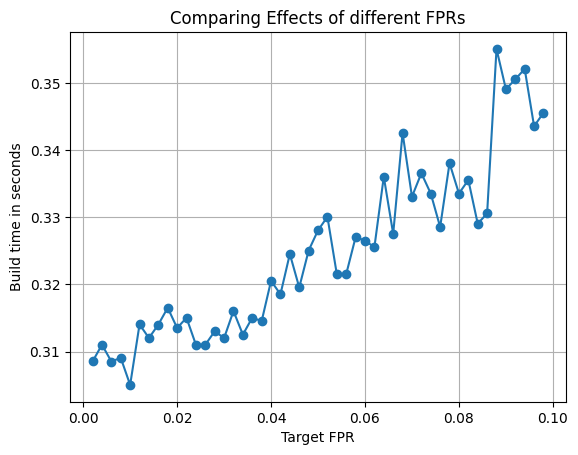

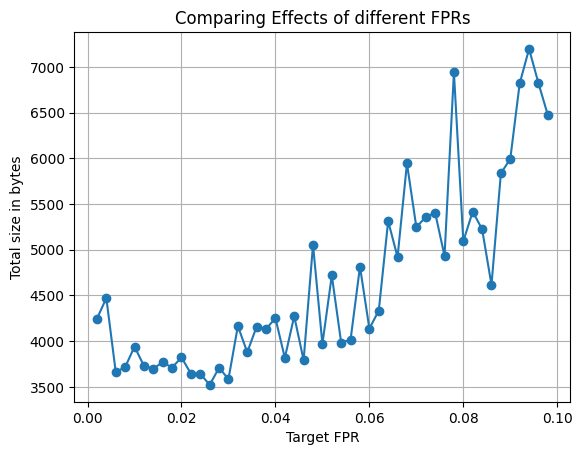

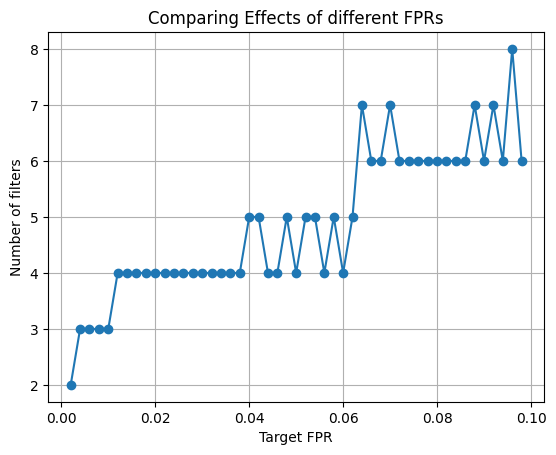

In [4]:
def test_fpr_range(start, end, step, revocation_rate):
    fpr = start
    n = 100_000
    fprs = []
    times = []
    byte_sizes = []
    depths = []

    num_included = math.floor(revocation_rate * n)
    num_excluded = math.floor((1.0 - revocation_rate) * n)

    while fpr <= end:
        # print(f"Building with: {fpr:.3f} fpr")
        result = take_measurement(num_included, num_excluded, [fpr])
        fprs.append(fpr)
        times.append(result["time"])
        byte_sizes.append(result["data_size"])
        depths.append(result["depth"])
        fpr = fpr + step
    plot_data(fprs, [times], [], "Target FPR", "Build time in seconds", "Comparing Effects of different FPRs")
    plot_data(fprs, [byte_sizes], [], "Target FPR", "Total size in bytes", "Comparing Effects of different FPRs")
    plot_data(fprs, [depths], [], "Target FPR", "Number of filters", "Comparing Effects of different FPRs")


test_fpr_range(0.002, 0.1, 0.002, 0.02)

## How does the cascades size and cascade depth correlate to number of revoked entries?
This is interesting to see how clearly we are leaking number of issuances.
We use 1mio issued certificates, bc that is what tum would roughly issue over a human lifetime, after which a diploma VC would expire.

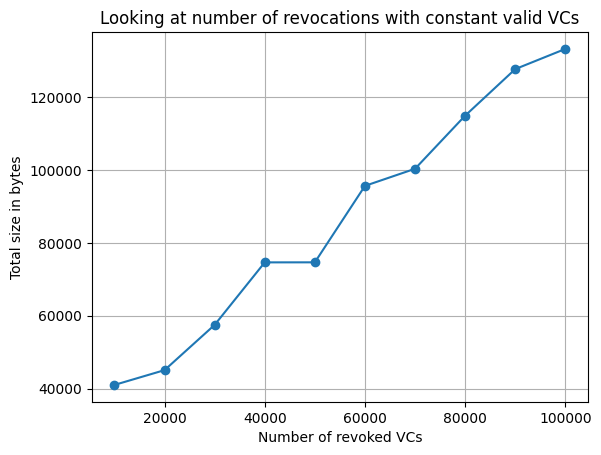

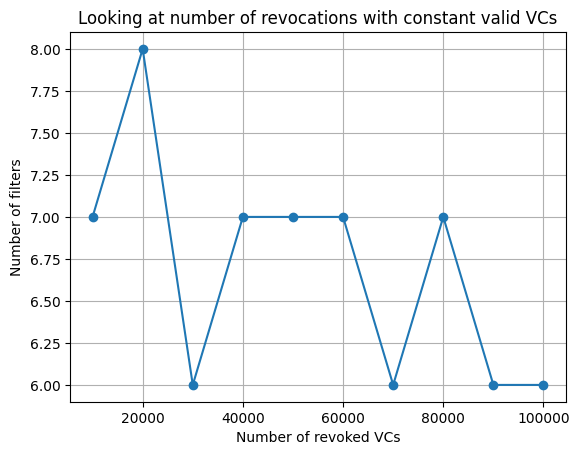

In [5]:
def test_increasing_inclusions(start, end, step):
    inclusions = []
    byte_sizes = []
    depths = []

    num_included = start
    num_excluded = 1_000_000

    while num_included <= end:
        result = take_measurement(num_included, num_excluded)
        inclusions.append(num_included)
        byte_sizes.append(result["data_size"])
        depths.append(result["depth"])
        num_included = num_included + step
    plot_data(inclusions, [byte_sizes], [], "Number of revoked VCs", "Total size in bytes", "Looking at number of revocations with constant valid VCs")
    plot_data(inclusions, [depths], [], "Number of revoked VCs", "Number of filters", "Looking at number of revocations with constant valid VCs")


test_increasing_inclusions(10_000, 100_000, 10_000)

## How does the cascades size and cascade depth correlate to number of unrevoked entries?
This is interesting to see how clearly we are leaking number of issuances.
We use ca 10% revocation to get numbers realistic for a diploma issuer like TUM.

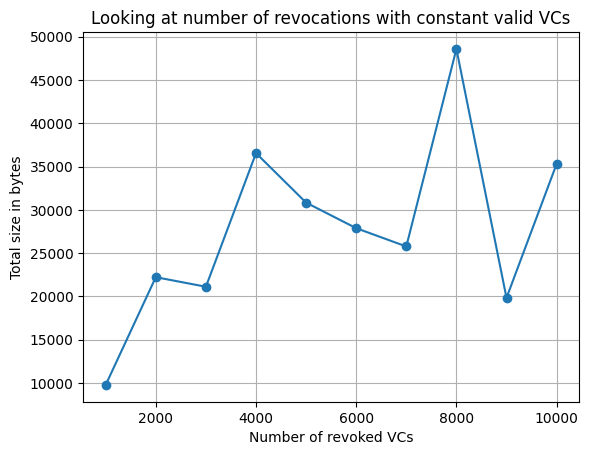

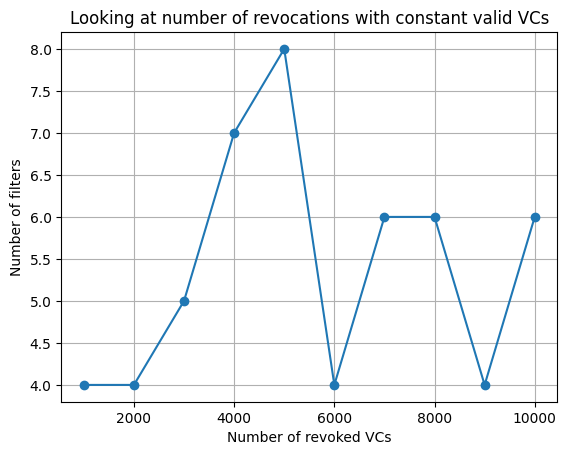

In [6]:
def test_increasing_exclusions(start, end, step):
    exclusions = []
    byte_sizes = []
    depths = []

    num_included = 1_000
    num_excluded = start

    while num_excluded <= end:
        result = take_measurement(num_included, num_excluded)
        exclusions.append(num_excluded)
        byte_sizes.append(result["data_size"])
        depths.append(result["depth"])
        num_excluded = num_excluded + step
    plot_data(exclusions, [byte_sizes], [], "Number of valid VCs", "Total size in bytes", "Looking at number of valid VCs with constant revocations")
    plot_data(exclusions, [depths], [], "Number of valid VCs", "Number of filters", "Looking at number of valid VCs with constant revocations")


test_increasing_inclusions(1_000, 10_000, 1_000)

## How does revocation rate affect the cascade?
Can you determine the revocation rate by just looking at the cascade?

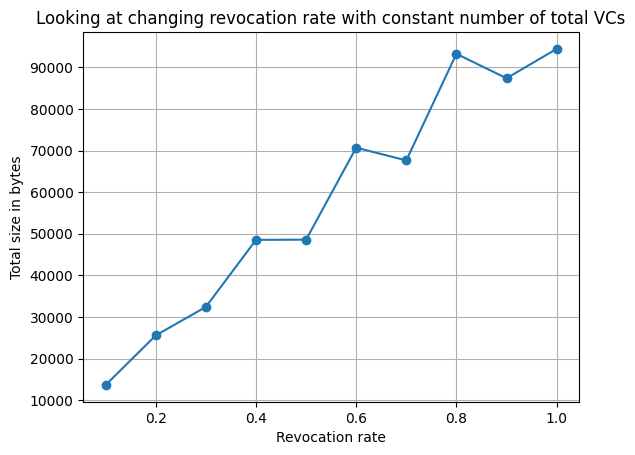

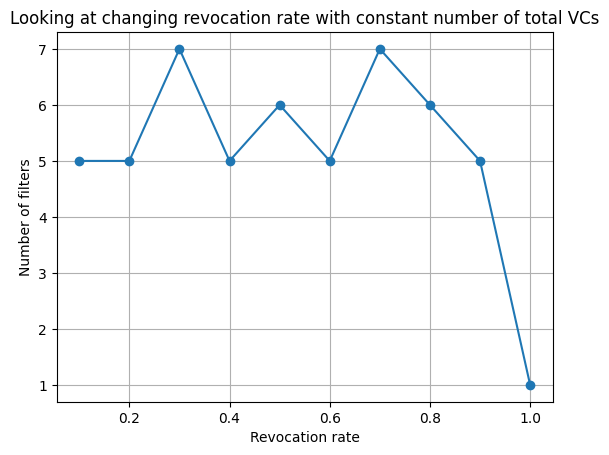

In [7]:
def test_revocation_rates(start, end, step):
    rate = start
    n = 100_000
    rates = []
    byte_sizes = []
    depths = []

    while rate <= end:
        num_included = math.floor(rate*n)
        num_excluded = math.floor((1.0-rate)*n)
        result = take_measurement(num_included, num_excluded)
        rates.append(rate)
        byte_sizes.append(result["data_size"])
        depths.append(result["depth"])
        rate = rate + step
    plot_data(rates, [byte_sizes], [], "Revocation rate", "Total size in bytes", "Looking at changing revocation rate with constant number of total VCs")
    plot_data(rates, [depths], [], "Revocation rate", "Number of filters", "Looking at changing revocation rate with constant number of total VCs")


test_revocation_rates(0.1, 1.0, 0.1)

## How long does it take to build cascades for bigger issuers?
Doing it in the end to have the fully optimized cascade.

In [ ]:
def test_sizes(start, end, step):
    n = start
    rates = []
    times = []
    byte_sizes = []
    depths = []

    while n <= end:
        num_included = math.floor(rate*n)
        num_excluded = math.floor((1.0-rate)*n)
        result = take_measurement(num_included, num_excluded)
        rates.append(rate)
        byte_sizes.append(result["data_size"])
        depths.append(result["depth"])
        rate = rate + step
    plot_data(rates, [byte_sizes], [], "Revocation rate", "Total size in bytes", "Looking at changing revocation rate with constant number of total VCs")
    plot_data(rates, [depths], [], "Revocation rate", "Number of filters", "Looking at changing revocation rate with constant number of total VCs")


test_revocation_rates(0.1, 1.0, 0.1)